# Notebook Overview
### Testing effect of recurrance length on prediction performance

## Inputs
The input variables for the RNN's in this notebook are the following:

    1. Time series data -- Variable
    2. Additional predictors -- day_of_week, avg_employees, perc_hours_today_before,
       perc_hours_yesterday_before, perc_hours_tomorrow_before

## Model Architecture
The architecture used in this notebook combines an RNN with a feed forward neural network. The RNN layer recieves n days of lagged shift data and makes a prediction for the shift on the n+1th day. This prediction is then concatenated with the additional predictors and fed into a traditional neural network(various shapes, see log files for all tested archectures) to generate a better prediction--the idea being that the RNN (through it's long and short term memory) learns patterns over time and the FF network adjusts these patterns based on additional information. 




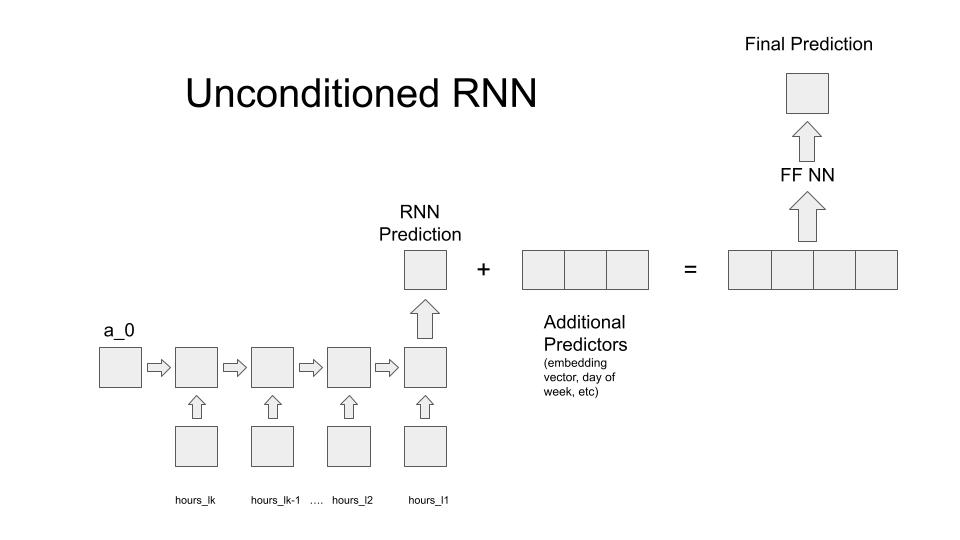

In [1]:
from IPython.display import Image
Image(filename="Images/Unconditioned_RNN_Diagram.jpeg")

In [1]:
import pandas as pd
import time
import datetime
import tensorflow as tf
from multiprocessing import Process
import numpy as np
LAGGED_DAYS = 14
index_dict = {'prov_id':0,'recurrence_start':1,'descriptors_start':LAGGED_DAYS+1}

#Logs hyperparameter specifications and other attributes of each run into a csv file
def log_model_info(model_info, path):
    try:
        df = pd.read_csv(path)
    except FileNotFoundError:
        #print(f"History csv not found at {path}. Creating new file.")
        df = pd.DataFrame()

    new_df = pd.DataFrame({k: [v] for k, v in model_info.items()})
    df = pd.concat([df, new_df], axis=0)
    df.to_csv(path, index=False)
    
#Expand categorical variables enumerated in labels to one-hot encodings
#Takes in pandas dataframe and returns tf tensor 
#Column ordering is preservered, with the convereted categorical columns dropped from the frame
#and their one-hot encodings concatenated to the end of the converted tensor
def expand_one_hot(labels,dataset):
    outList = []
    for label in labels:  
        col = dataset[label]
        ###Generate a dict for all unique values (Don't waste space encoding non important job id's)
        map = {}
        index = 0
        for element in col.unique():
            map[element] = index
            index += 1
        col = col.map(map)
        tensor = tf.one_hot(col,len(col.unique()))
        outList.append(tensor)
        dataset = dataset.drop(columns=[label])
    
    outList.insert(0,dataset)
    output = tf.concat(outList,1)
    return output

#Loads and preprocesses data from training_set.csv and crossvalidation_set.csv
def get_data():
    #nRows = 10000
    include_fields = ['hours','prov_id','day_of_week','avg_employees','perc_hours_today_before',
                      'perc_hours_yesterday_before', 'perc_hours_tomorrow_before']
    for i in range(1,LAGGED_DAYS+1):
        ##Inserts recurrence block starting at index 2
        include_fields.insert(i+1,f"hours_l{i}")
    
    train = pd.read_csv("/export/storage_adgandhi/PBJhours_ML/Data/Intermediate/train_test_validation/training_set.csv",usecols=include_fields).dropna()
    val = pd.read_csv("/export/storage_adgandhi/PBJhours_ML/Data/Intermediate/train_test_validation/crossvalidation_set.csv",usecols=include_fields).dropna()
    
    #Reorder columns to the order specified in include_fields [hours,prov_id,recurrence block,other block]
    train = train.reindex(columns=include_fields)
    val = val.reindex(columns=include_fields)
    
    train_inputs, train_labels = train.drop(['hours'], axis=1), train.filter(['hours'])
    val_inputs, val_labels = val.drop(['hours'], axis=1), val.filter(['hours'])

    vocab_size = len(train_inputs['prov_id'].unique())

    #Remove providers that appear in val set but not train
    train_providers = train_inputs['prov_id'].unique()
    val_providers = val_inputs['prov_id'].unique()
    for value in val_providers:
        if value not in train_providers:
            mask = (val_inputs['prov_id']!=value)
            val_inputs = val_inputs[mask]
            val_labels = val_labels[mask]

    # Remap prov_id's between 0 - # providers
    provider_map = {}
    index = 0
    for element in train_inputs['prov_id'].unique():
        provider_map[element]=index
        index +=1
    train_inputs['prov_id'] = train_inputs['prov_id'].map(provider_map)
    val_inputs['prov_id'] = val_inputs['prov_id'].map(provider_map)
    
    #expand categoricals to one-hot encodings
    train_inputs = expand_one_hot(['day_of_week'],train_inputs)
    val_inputs = expand_one_hot(['day_of_week'],val_inputs) 
    
    BUFFER_SIZE = 10000
    BATCH_SIZE = 128
    trainSet = tf.data.Dataset.from_tensor_slices((train_inputs,train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True)
    valSet = tf.data.Dataset.from_tensor_slices((val_inputs,val_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True)
    return trainSet,valSet,vocab_size


In [13]:
#Unconditioned RNN class, defines attributes of a model
class RNN(tf.keras.Model):
    #define all components of model
    def __init__(self,recurrence_length,lstm_units,dense_shape,embed_dim,vocab_size):
        super(RNN, self).__init__()
        self.embed_dim = embed_dim
        if embed_dim == 0:
            embed_dim += 1
        self.embeddings = tf.keras.layers.Embedding(vocab_size,embed_dim) 
        self.recurrence_length = int(recurrence_length)
        self.lstm = tf.keras.layers.LSTM(lstm_units)
        self.dense_layers = []
        for width in dense_shape:
            if width == 1:
                break
            self.dense_layers.append(tf.keras.layers.Dense(width,activation=tf.nn.relu))
            self.dense_layers.append(tf.keras.layers.BatchNormalization())
        self.out = tf.keras.layers.Dense(1)
       
    
    #define model architecture
    def call(self, inputs, training=False):
        #prov_id is first column
        time_series = tf.reverse(tf.expand_dims(inputs[:,index_dict['recurrence_start']:index_dict['recurrence_start']+self.recurrence_length],2),[1])
        additional_inputs = inputs[:,index_dict['descriptors_start']:]
        
        x = self.lstm(time_series)
        if self.embed_dim != 0:    
            embedding_vectors = self.embeddings(inputs[:,index_dict['prov_id']])
            x = tf.concat([x,additional_inputs,embedding_vectors],1)
        else:
            x = tf.concat([x,additional_inputs],1)
        for layer in self.dense_layers:
            x = layer(x)
        
        return self.out(x)

class RNN_Conditioned(tf.keras.Model):
    #define all components of model
    def __init__(self,recurrence_length,lstm_units,dense_shape,embed_dim,vocab_size):
        super(RNN_Conditioned, self).__init__()
        self.embed_dim = embed_dim
        self.recurrence_length = int(recurrence_length)
        self.units = lstm_units
        self.transform = tf.keras.layers.Dense(lstm_units-embed_dim)
        if embed_dim == 0:
            embed_dim += 1
        self.embeddings = tf.keras.layers.Embedding(vocab_size,embed_dim) 
        self.lstm = tf.keras.layers.LSTM(lstm_units)
        self.dense_layers = []
        for width in dense_shape:
            if width == 1:
                break
            self.dense_layers.append(tf.keras.layers.Dense(width,activation=tf.nn.relu))
            self.dense_layers.append(tf.keras.layers.BatchNormalization())
        self.out = tf.keras.layers.Dense(1)
       
    
    #define model architecture
    def call(self, inputs, training=False):
        #prov_id is first column
        time_series = tf.reverse(tf.expand_dims(inputs[:,index_dict['recurrence_start']:index_dict['recurrence_start']+self.recurrence_length],2),[1])
        additional_inputs = inputs[:,index_dict['descriptors_start']:]
        
        additional_inputs = inputs[:,index_dict['descriptors_start']:]
        transformed_inputs = self.transform(additional_inputs)
        if self.embed_dim != 0:    
            embedding_vectors = self.embeddings(inputs[:,index_dict['prov_id']])
            transformed_inputs = tf.concat([transformed_inputs,embedding_vectors],1)
        c_0 = tf.convert_to_tensor(np.random.random([128, self.units]).astype(np.float32))
       #h_0 = tf.convert_to_tensor(np.random.random([128, self.units]).astype(np.float32))
        h_0 = transformed_inputs
        x = self.lstm(time_series, initial_state=[h_0,c_0])
           
       
        for layer in self.dense_layers:
            x = layer(x)
        
        return self.out(x)
    

In [14]:
learning_rate = 1e-3
EPOCHS = 5
# Callback function to decrease learning rate
def decay(epoch):
  if epoch < 3:
    return learning_rate
  elif epoch >= 3 and epoch < 7:
    return learning_rate/10
  else:
    return learning_rate/100

# base dict of values to log for each run. Some values are common to every run
base_dict = {'Recurrance length':-1,'LSTM Units':16,'Embedding Dimension':0,'FF model shape':[8,8,4,1],'Initial Learning Rate':learning_rate,'Regularization':"Batch Normalization",'Metric':"mse",'Training loss':-1,'Val loss':-1,
             'time_start':-1,'time_duration':-1,'Epochs':EPOCHS,'Columns':['day_of_week','avg_employees','perc_hours_today_before',
             'perc_hours_yesterday_before', 'perc_hours_tomorrow_before'],'LSTM type':"Conditioned",'user':"asharma"}

# Worker function for multiprocessing Process. Trains an RNN with the specified recurrance length
def train_and_test_models(recurrance_length,lstm_units,dense_shape,embed_dim):
    print(f"Started process with recurrance length: {recurrance_length}")
    trainSet,valSet,vocab = get_data()
    start_time = time.time()
    start_date = datetime.datetime.now()
    with tf.device('/cpu:0'):
        model = RNN_Conditioned(recurrance_length,lstm_units,dense_shape,embed_dim,vocab)
        model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])
        callbacks = [
        tf.keras.callbacks.LearningRateScheduler(decay)
        ]
        history = model.fit(trainSet, epochs=EPOCHS, callbacks=callbacks,verbose=0)
        valLoss, metric = model.evaluate(valSet)

    param_dict = base_dict.copy()
    time_taken = str(datetime.timedelta(seconds=(time.time()-start_time)))
    train_loss = history.history['loss'][EPOCHS-1]
    param_dict['Recurrance length'] = recurrance_length
    param_dict['LSTM Units'] = lstm_units
    param_dict['Embedding Dimension'] = embed_dim
    param_dict['FF model shape'] = dense_shape
    param_dict['Training loss'] = train_loss
    param_dict['Val loss'] = valLoss
    param_dict['time_start'] = start_date
    param_dict['time_duration'] = time_taken
    log_model_info(param_dict,'/users/facsupport/asharma/RNN-shifts/rnn_tuning_history.csv')
    print("COMPLETED WORK")


In [ ]:
shapes = [[16,8,1],[8,8,8,1],[1],[8,1]]
units = [16,32]
tasks = []
for shape in shapes:
    for size in units:  
        tasks.append(Process(target=train_and_test_models,args=(14,size,shape,10)))
        #tasks.append(Process(target=train_and_test_models,args=(14,size,shape,0)))

for task in tasks:
    task.start()
for task in tasks:
    task.join()

Started process with recurrance length: 3
Started process with recurrance length: 7

Started process with recurrance length: 10Started process with recurrance length: 11
Started process with recurrance length: 14


<AxesSubplot:xlabel='Recurrance length'>

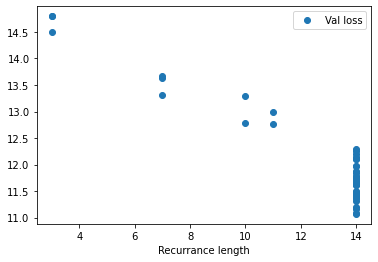

In [1]:
import pandas as pd
data = pd.read_csv('/users/facsupport/asharma/RNN-shifts/rnn_tuning_history.csv')
data.columns
data.plot(x='Recurrance length',y='Val loss',style='o')